### EDA of the S&P500 dataset

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, seasonal_decompose

In [2]:
ticker = "^GSPC"
df = yf.download(ticker,
                 start="2016-01-01",
                 end="2025-01-01",
                 progress=False)

s = df['Close'].resample('W').mean()

C:\Users\USER\AppData\Local\Temp\ipykernel_28656\226217555.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,


<Axes: xlabel='Date'>

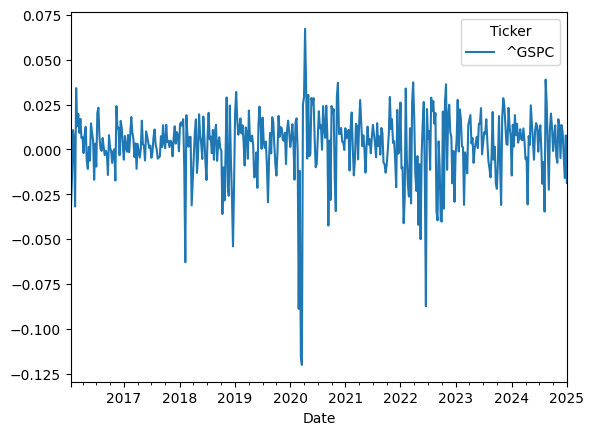

In [12]:
log_returns = np.log(s).diff().dropna()
log_returns.plot()

<Axes: xlabel='Date'>

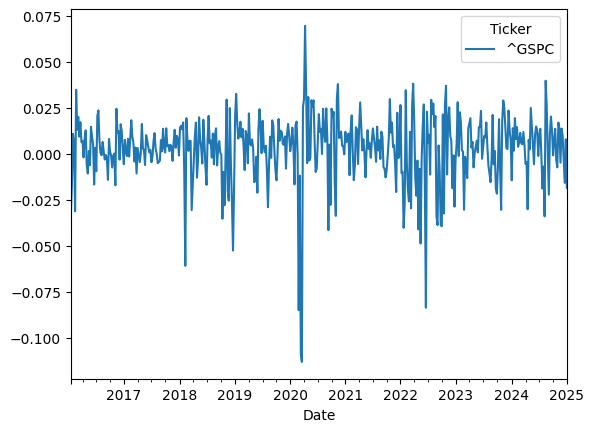

In [ ]:
simple_returns = s.pct_change().dropna()
simple_returns.plot

### STL

In [16]:
stl = STL(s, seasonal=53, robust=True)
stl_res = stl.fit()

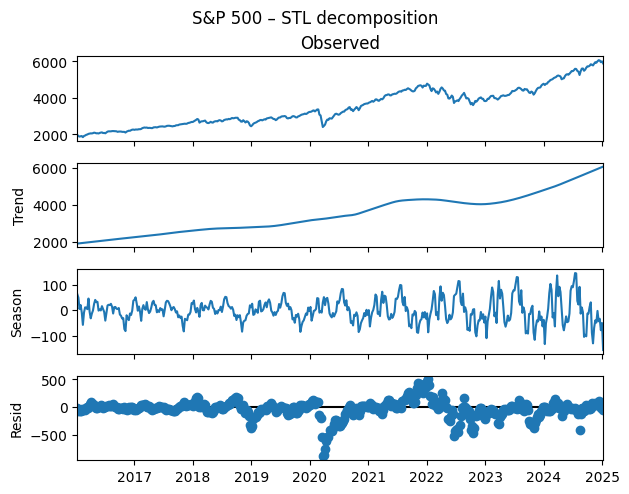

In [17]:
fig1 = stl_res.plot()
fig1.suptitle("S&P 500 – STL decomposition", y=1.02)
plt.show()

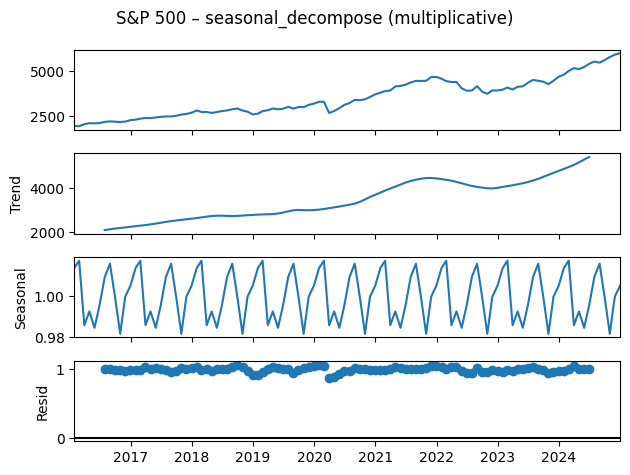

In [23]:
# Classic X-11–style additive or multiplicative decomposition
# works fine when seasonality is roughly constant over time
decomp = seasonal_decompose(s, model='multiplicative', period=12)
fig2 = decomp.plot()
fig2.suptitle("S&P 500 – seasonal_decompose (multiplicative)")
plt.tight_layout()
plt.show()

### Random walk testing

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# suppose `s` is your monthly price series
adf_result = adfuller(s)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}') # p-value is greater than 0.05, you fail to reject the null and the series is likely non-stationary (it's a random walk then).

kpss_stat, pval, *_ = kpss(s, regression='c')
print("KPSS p‐value:", pval) # p ≪ 0.01, so strongly reject stationarity

ADF Statistic: 0.8604
p-value: 0.9926
KPSS p‐value: 0.01


C:\Users\USER\AppData\Local\Temp\ipykernel_10932\2499938127.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, pval, *_ = kpss(s, regression='c')


In [26]:
# Apply first-order differencing
# Will see p-value is less than 0.05, you can reject the null hypothesis and conclude the series is stationary.
data_diff = s.diff().dropna()
adf_result_diff = adfuller(data_diff)
print(f'Differenced ADF Statistic: {adf_result_diff[0]:.4f}')
print(f'p-value: {adf_result_diff[1]:.4f}')

Differenced ADF Statistic: -9.0649
p-value: 0.0000


### EMH weak test

In [27]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox

r = s.pct_change().dropna()
lb_stat, lb_pval = acorr_ljungbox(r, lags=[5,10,20], return_df=False)
print("Ljung–Box p-values:", lb_pval)

Ljung–Box p-values: lb_pvalue


### Diag plot

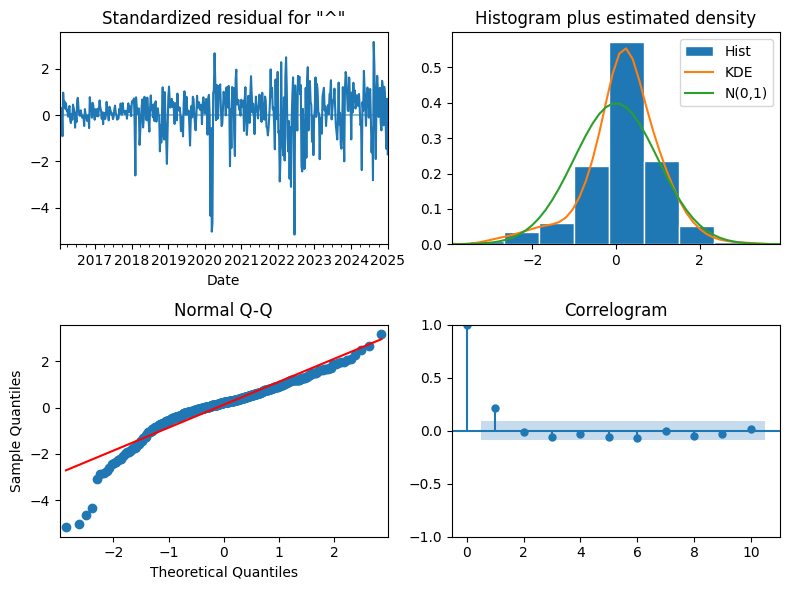

In [21]:
# Built‐in 4-panel diagnostics
from statsmodels.tsa.arima.model import ARIMA

res = ARIMA(s, order=(0,1,0)).fit()  # 0, 0, 0 for regular data, 0, 1, 0 to see effect of difference

res.plot_diagnostics(figsize=(8, 6))
plt.tight_layout()
plt.show()

Residuals Plot - should look like white noise

Histogram - Histogram and KDE (orange) should closely follow the normal curve.

Q-Q Plot - Points should fall along the red line.

Correlogram (ACF Plot) - Bars (autocorrelations) should lie within the blue confidence bounds.

### Plot ACF and PACF

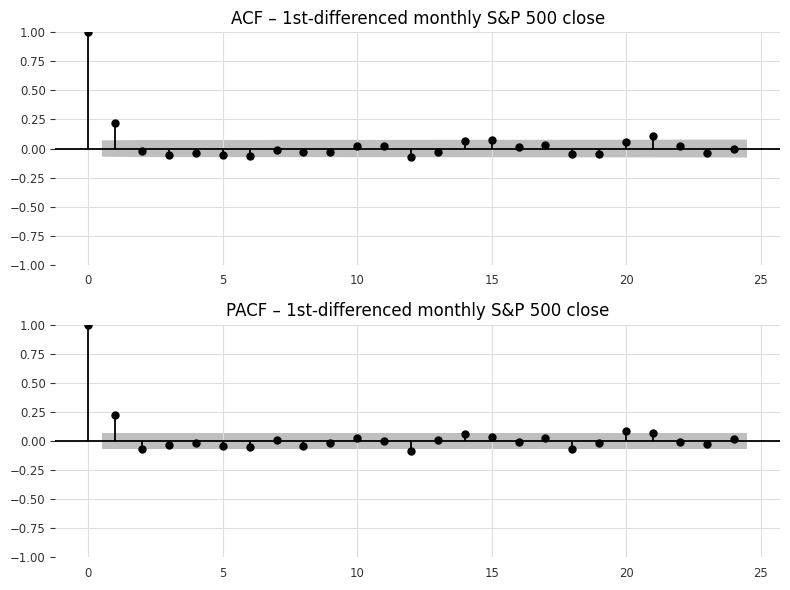

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# make stationary
s_diff = s.diff().dropna()

fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# ACF
plot_acf(s_diff, lags=24, ax=ax[0]) # 24 lags = two years of monthly data
ax[0].set_title('ACF – 1st-differenced monthly S&P 500 close')

# PACF
plot_pacf(s_diff, lags=24, method='ywm', ax=ax[1])
ax[1].set_title('PACF – 1st-differenced monthly S&P 500 close')

plt.tight_layout()
plt.show()

IF the bar doesnt die down (>0.9) -> not stationary 

Large ACF spike at lag 1 but nothing else? -> likely an MA(1) component.

Large PACF spike at lag 1 but nothing else? -> likely an AR(1) component.

| If you see…                              | Typical model hint        |
| ---------------------------------------- | ------------------------- |
| ACF cuts off after lag q, PACF tails off | MA(q)                     |
| PACF cuts off after lag p, ACF tails off | AR(p)                     |
| Both tail off                            | Mixed ARMA / higher-order |

Be sure to check for stationary first, these plot only work well after series is made to be roughly stationary after all

You can see significant in lag 1, 2, maybe 3, and 12? (out of grey zone)

### Denoising with wavelet transform

base on "An Evaluation of Deep Learning Models for Stock, Market Trend Prediction" research paper

In [38]:
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
import numpy as np

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# reindex and ffill
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# fill missing values
series = fill_missing_values(series)

C:\Users\USER\AppData\Local\Temp\ipykernel_10932\971275677.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [39]:
import pywt

# extract raw numpy values
raw_vals = series.values().flatten()
n = len(raw_vals)

# choose a wavelet and maximum possible level
wavelet = 'db4'
max_level = pywt.dwt_max_level(n, pywt.Wavelet(wavelet))

# perform the decomposition
coeffs = pywt.wavedec(raw_vals, wavelet, level=max_level)

# estimate noise σ from the finest‐scale detail coeffs
# (median absolute deviation / 0.6745)
detail_coeffs = coeffs[-1]
sigma = np.median(np.abs(detail_coeffs)) / 0.6745

# compute universal threshold √(2·log(n))·σ
uthresh = sigma * np.sqrt(2 * np.log(n))

# soft‐threshold all detail levels
denoised_coeffs = [coeffs[0]] + [
    pywt.threshold(c, uthresh, mode='soft') for c in coeffs[1:]
]

# reconstruct the signal and trim to original length
denoised_vals = pywt.waverec(denoised_coeffs, wavelet)[:n]

# build a new TimeSeries with the same index & freq
series_denoised = TimeSeries.from_times_and_values(
    series.time_index,
    denoised_vals.reshape(-1, 1),
    freq=series.freq
)

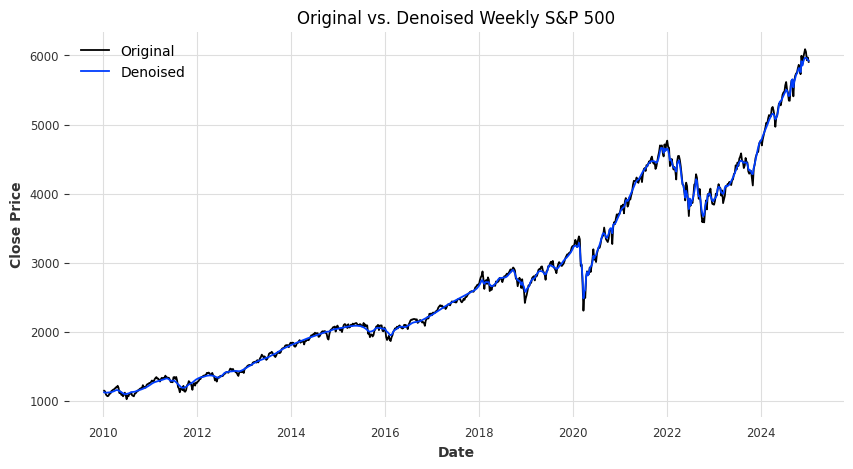

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

orig = pd.Series(
    series.values().flatten(), 
    index=series.time_index,
    name='Original'
)

den = pd.Series(
    series_denoised.values().flatten(), 
    index=series_denoised.time_index,
    name='Denoised'
)

plt.figure(figsize=(10,5))
plt.plot(orig, label='Original')
plt.plot(den,  label='Denoised')
plt.legend()
plt.title('Original vs. Denoised Weekly S&P 500')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

### Periodogram for seasonality

In [42]:
import matplotlib.pyplot as plt
from scipy.signal import periodogram

ticker = "^GSPC"
df = yf.download(ticker,
                 start="2016-01-01",
                 end="2025-01-01",
                 progress=False)

s = df['Close'].resample('W').mean()

C:\Users\USER\AppData\Local\Temp\ipykernel_69456\2080011306.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,


In [43]:
def plot_periodogram(ts, detrend='linear', ax=None):
    """
    ts      : pd.Series or array‑like of weekly data (shape N,)
    detrend : 'linear', 'constant', or callable
    """
    # --- 1) Turn ts into a plain 1‑D numpy array ---
    data = np.asarray(ts)
    if data.ndim > 1:
        data = data.squeeze()
    if data.ndim != 1:
        raise ValueError(f"Time series must be 1D; got shape {data.shape}")

    # --- 2) Use weeks‑per‑year as fs (≈52.14) ---
    fs = float(pd.Timedelta("365D") / pd.Timedelta("7D"))

    # --- 3) Compute periodogram ---
    freqs, spec = periodogram(
        data,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum'
    )

    # --- 4) Plot ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,4))

    ax.step(freqs, spec, where='mid', color="purple")
    ax.set_xscale("log")

    # seasonal tick marks
    ticks   = [1, 2, 4, 6, 12, 26, 52, 104]
    labels  = [
        "Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)",
        "Monthly (12)", "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"
    ]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=30, ha='right')

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram of S&P 500 Weekly Close")
    plt.tight_layout()
    return ax

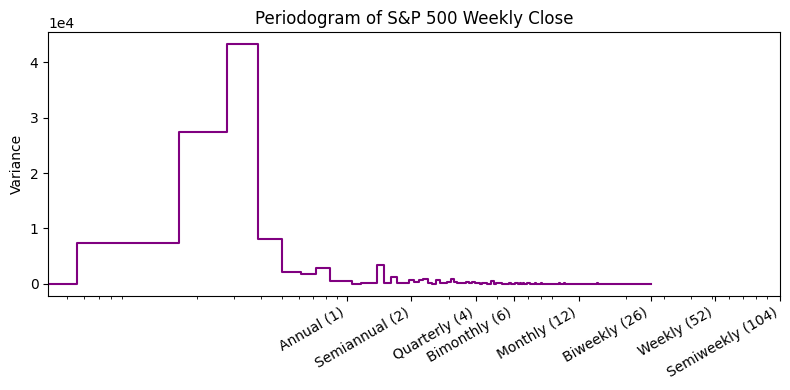

In [44]:
ax = plot_periodogram(s, detrend='linear')
plt.show()